In [1]:
import numpy as np
from scipy import sparse
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import random
import gudhi

In [2]:
class geometric_network():
    def __init__(self, network_type, size, **kwargs):
        ####################################
        ##### Geometric Network Object #####
        ####################################
        
        ### input -- network_type:
        ##                      2D_lattice: creates 2d lattice of given tiling-can be triangular, square, hexagonal
        #                                   --Additional Arguments--
        #                                     tiling = 3,4,6
        #                                     periodic = bool (connects the edge of the grid to the opposite edge)
        ##                      ring_lattice: creates a ring graph with each node degree 2
        #                                    --Additional Arguments--
        #                                     banded = bool
        #                                     band_length = gonna connect this many closest neigbors (skipping the 
        #                                                   adjacent nodes from both sides because they are already 
        #                                                   connected) from both sides to every node
        #                                     
        #                                     
        ### input -- size: network size, if 2D_lattice, then there will be size^2 many nodes.
        
        ### attribute -- geometric_network.N
        ### attribute -- geometric_network.M
        ### attribute -- geometric_network.graph
        ### attribute -- geometric_network.pos
        ### attribute -- geometric_network.A
        ### attribute -- geometric_network.text 
        
        ### function -- geometric_network.display(n_size, labels = Bool): take a sneakpeak on the networkx object
        ### function -- geometric_network.add_noise_to_geometric(noise_type, d2): add two types of noise
        #                                   either 'ER_like' or 'k_regular' of degree d2
        ### function -- geometric_network.run_excitation(Trials, p, T, seed, threshold): run 
        #                                   the excitation according to these parameters
        
        ### function -- geometric_network.spy_first_activation(first_activation_times): visualize the first
        #                                   activation, input of the functin is the 2nd output of run_excitation
        
        if network_type == '2D_lattice': 
            tiling = kwargs['tiling']
            per = kwargs['periodic']
            if tiling == 3: 
                self.graph = nx.triangular_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                

            elif tiling == 4: 
                self.graph = nx.grid_2d_graph(size, size, periodic = per)
                self.pos = dict( (n, n) for n in self.graph.nodes() )
                self.labels = dict( ((i, j), i * size + j) for i, j in self.graph.nodes() )
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                
            elif tiling == 6: 
                self.graph = nx.hexagonal_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
            
        elif network_type == 'ring_lattice':# TODO: banding for every node
            self.graph = nx.cycle_graph(size)
            theta = (2*np.pi)/size
            self.pos = dict((i,(np.sin(theta*i),np.cos(theta*i))) for i in range(size))
            self.M = len(self.graph.edges())
            self.N = len(self.graph.nodes())
            self.text = 'Ring Lattice'
            if kwargs['banded']:
                if kwargs['band_length'] >= int(self.N/2)-1: raise ValueError('Band length cannot exceed the half of the size of the network')
                if kwargs['band_length'] <2: raise ValueError('Band length should be a positive integer greater 1 since the closest neighbors are already connected')
                for u in range(self.N):
                    for i in range(2,kwargs['band_length']+1):# ranges from 2 to k+2 to avoid the closest node and start
                        ## banding from the second closest node
                        if u + i >= self.N: v = u + i - self.N
                        else: v = u + i
                        self.graph.add_edge(u, v)
                        if u - i < 0: v = self.N + u - i
                        else: v = u - i
                        self.graph.add_edge(u, v)
                self.text = self.text + ' w/ bandlength %d'%kwargs['band_length']
            else:self.text = self.text + ' w/ bandlength 0'
                        
        else: raise ValueError('network type can be a lattice or a ring')
            
        self.A = nx.adjacency_matrix(self.graph)## use .toarray() or .todense() attributes to call the sparse matrix
              
    def display(self, n_size = 15, labels = True):
        
        try: return(nx.draw(self.graph, pos = self.pos, node_size = n_size, with_labels = labels, font_weight = 'bold'))
        
        except: return(nx.draw(self.graph, with_labels = labels, font_weight = 'bold'))
        
    def add_noise_to_geometric(self, noise_type, d2):
        
        # this function adds nongeometric edges to the network that are long range. Depending on the 'noise_type'
        # the way we add these long range edges differ. If noise_type = ER_like, then there will be d2 many
        # non geometric edges ON AVARAGE for every node. When the noise_type = k_regular, every node will 
        # have exactly d2 many long range edges
        
        
        if noise_type == 'ER_like':   
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
                
            edges_built = 0
            
            while edges_built <= M/2:
                
                nodes_to_connect = [random.randint(0,self.N-1) for i in range(2)]
                
                if nodes_to_connect[0] == nodes_to_connect[1]: #no self-loops
                    edges_built = edges_built
                elif self.A.toarray()[nodes_to_connect[0]][nodes_to_connect[1]] == 1 or self.A.toarray()[nodes_to_connect[1]][nodes_to_connect[0]] == 1: # no existing loops
                    edges_built = edges_built
                else: 
                    self.graph.add_edge(nodes_to_connect[0],nodes_to_connect[1])
                    edges_built = edges_built + 1
            self.text = self.text + ' & ER-like noise w/ degree %d'%d2

                    
        elif noise_type == 'k_regular':
            
            self.text = self.text + ' & k-regular noise w/ degree %d'%d2
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
            flag_2 = True
            
            while flag_2:
                flag_2 = False
                #build stubs
                stubs = np.zeros(M)
                for i in range(self.N):
                    index = (i*d2) + np.arange(d2)
                    stubs[index[0]:index[-1]+1] = (i) * np.ones(d2)
                    
                #build undirected link list
                link_list = np.zeros((int(M/2),2))
                for m in range(int(M/2)):
                    flag_1 = True # turn on flag to enter while loop
                    count = 0
                    while flag_1:
                        flag_1 = False #turn off flag to exit while loop
                        rand = [random.randint(0,len(stubs)-1) for i in range(2)]
                        
                        node_A = int(stubs[rand[0]])
                        node_B = int(stubs[rand[1]])
                                                
                        if node_A == node_B: flag_1 = True
                        
                        for n in range(m):
                            if link_list[n,0] == node_A and link_list[n,1] == node_B:
                                flag_1 = True
                            if link_list[n,0] == node_B and link_list[n,1] == node_A:
                                flag_1 = True
                            if self.A.toarray()[node_A][node_B] == 1 or self.A.toarray()[node_B][node_A] == 1:
                                flag_1 = True
                                
                        count = count +1
                        
                        if count > M: flag_2 = True ; break
                            
                    #make link       
                    link_list[m,0] = node_A
                    link_list[m,1] = node_B
                    
                    #remove stubs from list
                    stubs = np.delete(stubs,[rand[0],rand[1]])
            
            #build network
            for m in range(int(M/2)):
                self.graph.add_edge(link_list[m,0],link_list[m,1])
            
        else: raise InputError('Noise type can only be ER_like or k_regular')
    
    def excitation(self, p, T, seed, threshold, ax = None, spy = False):
        
        n = self.N
        x_1 = sparse.lil_matrix(((n,T+1)), dtype = bool)
        activation_times = np.ones(n, dtype = int)*T
        excited_nodes = self.A[seed].nonzero()[1]
        deg = len(excited_nodes)
        
        ps = np.array([random.uniform(0,1) for i in range(deg)])
        pss = np.array([1-p for i in range(deg)])
        
        vals = ps > pss
        
        for i in range(deg): x_1[excited_nodes[i],0] = vals[i]
            
        t = 0
        all_nodes = set([k for k in range(n)])
        
        while t<T and len(excited_nodes)>0 and np.any(activation_times==T):
            x_old = x_1.toarray()[:,t]
            excited_nodes = np.nonzero(x_old)[0]         
            activation_times[excited_nodes] = np.minimum(activation_times[excited_nodes],np.array([t]*len(excited_nodes)))
            activation_times = activation_times.astype(np.int32)
            t+=1
            for j in list(all_nodes-set(excited_nodes)): 
                ids = np.nonzero(self.A[j])[1]
                rands = [random.uniform(0,1) for i in range(len(ids))]
                summ = 0 
                
                for y,e in enumerate(ids):
                    if x_old[e]*rands[y] > 1-p:
                        summ = summ + x_old[e]*rands[y]
                        
                x_1[j,t] = bool(summ/len(ids)>=threshold)
                     
        if spy: ax.imshow(x_1.todense())
        
        if np.any(activation_times == T): 
            activation_retry = self.excitation(p, T, seed, threshold, ax = ax, spy = spy)
            return(activation_retry)
            
        else: return(activation_times)
    
    
    def run_excitation(self, Trials, p, T, seed, threshold, ax = None):
        
        n = self.N
        
        first_excitation_times = np.zeros((n,Trials))
        
        if ax is not None: 
            for i in range(Trials):
    
                first_exct = self.excitation(p = p, T = T, seed = seed, threshold = threshold, ax = ax[i], spy = True)
                first_excitation_times[:,i] = first_exct
                ax[i].set_title('Trial %d for %s'%(i+1, self.text), fontsize = 25)
                ax[i].set_xlabel('Time', fontsize = 35)
                ax[i].set_ylabel('Node ID',fontsize = 35)
                ax[i].set_xticks([5*t for t in range(int(T/5)+1)])
                ax[i].set_yticks([10*t for t in range(int(n/10))])
                ax[i].tick_params('both', which = 'major', labelsize = 15)
            plt.tight_layout()
            
        else:
            for i in range(Trials):
    
                first_exct = self.excitation(p = p, T = T, seed = seed, threshold = threshold)
                first_excitation_times[:,i] = first_exct
        
        return(first_excitation_times)
    

    def spy_first_activation(self, first_activation_times):
        
        fig,ax = plt.subplots(1,1,figsize = (10,8))
        
        pos = ax.imshow(first_activation_times, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',extent = [0.5,Trials+0.5,0,n])
        ax.set_title('First Activation Times for %s'%self.text, fontsize = 20)
        ax.set_xlabel('Trials', fontsize = 15)
        ax.set_ylabel('Node ID', fontsize = 15)
        ax.set_xticks([i for i in range(1,Trials+1)])
        
        fig.colorbar(pos, ax = ax)
        
    def average_over_trials(self, first_activation_times):return(np.mean(first_activation_times, axis = 1))
    
    def make_distance_matrix(self, p, T, threshold, Trials, spy_distance = False):
        n = self.N
        D = np.zeros((n,n))
        
        for i in range(n):
            D[i] = self.average_over_trials(self.run_excitation(Trials, p, T, i, threshold ))
        
        if spy_distance: 
            fig,ax = plt.subplots(1,1, figsize = (15*int(n/20),10*int(n/20)))
            pos = ax.imshow(D, origin = 'lower', interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,n-0.5,-0.5,n-0.5])
            ax.set_title('Distance Matrix for %s'%self.text, fontsize = 20)
            ax.set_ylabel('Excitation starting from node i', fontsize = 15)
            ax.set_xlabel('First time node j gets activated', fontsize = 15)
            ax.set_xticks([i*5 for i in range(int(n/5))])
            ax.set_yticks([i*5 for i in range(int(n/5))])

            fig.colorbar(pos, ax = ax)
        return(D)
    
    def compute_persistence(self, distances, spy = False):    
        rips_complex = gudhi.RipsComplex(distance_matrix = distances/np.max(distances), max_edge_length = 1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence(min_persistence = 0.0)
        if spy: 
            gudhi.plot_persistence_diagram(diag)
            #plt.savefig('/Users/bengieru/persistence.pdf')
        return(diag)
    
    def one_d_Delta(self, persistence):
        oned_holes = [(0,0)]
        for i in range(len(persistence)):
            if persistence[i][0] == 1:
                oned_holes.append(persistence[i][1])
        oned_holes = oned_holes
        oned_holes = np.array(oned_holes)
        persistence_life_times = oned_holes[:,1]-oned_holes[:,0]
        Delta = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[-2]
        return(Delta)

In [13]:
a = [True,False]
np.any(a)

True

# 1) Sample Network Initialization
   ### network_type = 2D_lattice or ring_lattice,
   ### size = integer

In [4]:
network = geometric_network('2D_lattice', size = 50, tiling = 3, periodic = False)

*  ## 2D_lattice
    * ###  tiling = 3,4,6
    * ###  periodic = Bool

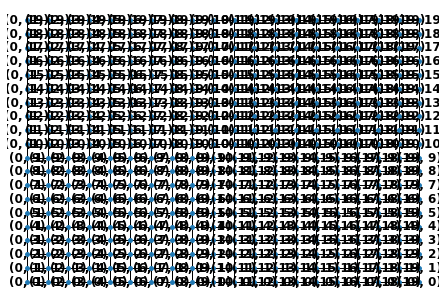

In [5]:
n = 20
t = 4 # tiling for 2D-lattice only
twoD_latt = geometric_network('2D_lattice', size = n, tiling = t, periodic = False)
twoD_latt.display()

 *  ## ring_lattice
     * ### banded = False

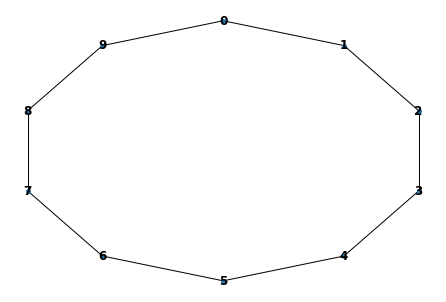

In [6]:
n = 10
ring_latt = geometric_network('ring_lattice', size = n, banded = False)
ring_latt.display()

 *  ## banded_ring_lattice
     * ### banded = True
     * ### band_length = 2

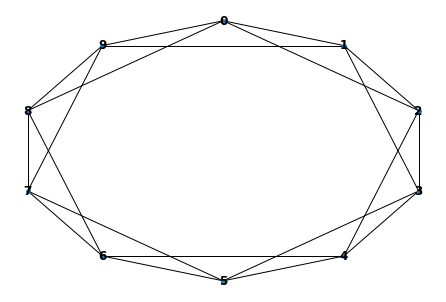

In [7]:
n = 10
banded_ring_latt = geometric_network('ring_lattice', size = n, banded = True, band_length = 2)
banded_ring_latt.display()

 *  ## noisy_ring_lattice
     * ### banded = Bool
     * ### band_length = None
 *  ### noisy_ring_lattice.add_noise_to_geometric()
     * ### noise_type = ER_like
     * ### d2 = int

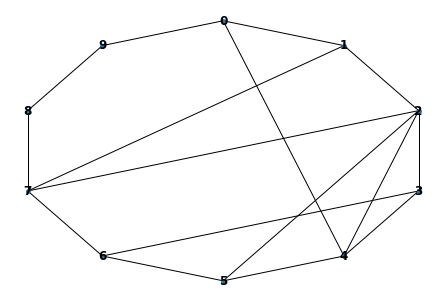

In [8]:
d2 = 1 # nongeometric degree
ring_latt_er_noise = geometric_network('ring_lattice', size = n, banded = False)
ring_latt_er_noise.add_noise_to_geometric('ER_like', d2)
ring_latt_er_noise.display()

 *  ## noisy_ring_lattice
     * ### banded = Bool
     * ### band_length = None
 *  ### noisy_ring_lattice.add_noise_to_geometric()
     * ### noise_type = k_regular
     * ### d2 = int

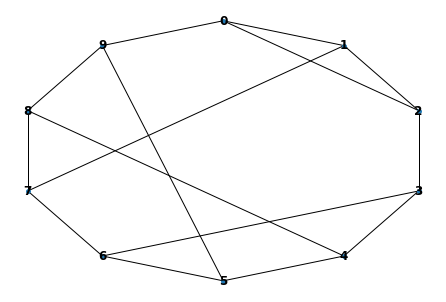

In [9]:
n = 10
d2 = 1
ring_latt_k_regular =  geometric_network('ring_lattice', size = n, banded = False)#, band_length = 5)
ring_latt_k_regular.add_noise_to_geometric('k_regular', d2)
ring_latt_k_regular.display()

# 2) Sample Excitation Simulation
   ### Use .run_exciation() method for the desired network. Output is the first activation times

In [10]:
p = 0.65 # cascade spreading probablioty
T = 100 # number of iterations
seed = int(n/2) # node that the spread starts
threshold = 0.1 # resistence of the node to it's neighbors' excitation level
Trials = 2 # number of trials

[1 9] [False False]
[0 2] [False False]
[1 3] [False False]
[2 4] [False  True]
[4 6] [ True  True]
[6 8] [ True False]
[7 9] [False False]
[0 8] [False False]
[1 9] [False False]
[0 2] [False False]
[1 3] [False  True]
[3 5] [ True  True]
[5 7] [ True False]
[6 8] [False False]
[7 9] [False False]
[0 8] [False False]
[1 9] [False False]
[0 2] [False  True]
[2 4] [ True  True]
[4 6] [ True False]
[5 7] [False False]
[6 8] [False False]
[7 9] [False False]
[0 8] [False False]
[1 9] [ True False]
[1 3] [ True False]
[2 4] [False False]
[3 5] [False False]
[4 6] [False False]
[5 7] [False False]
[6 8] [False False]
[7 9] [False False]
[0 8] [False False]
[0 2] [ True False]
[1 3] [False False]
[2 4] [False False]
[3 5] [False False]
[4 6] [False False]
[5 7] [False False]
[6 8] [False False]
[7 9] [False False]
[0 8] [ True False]
[1 9] [ True  True]
[1 3] [ True False]
[2 4] [False False]
[3 5] [False False]
[4 6] [False False]
[5 7] [False False]
[6 8] [False False]
[7 9] [False  True]


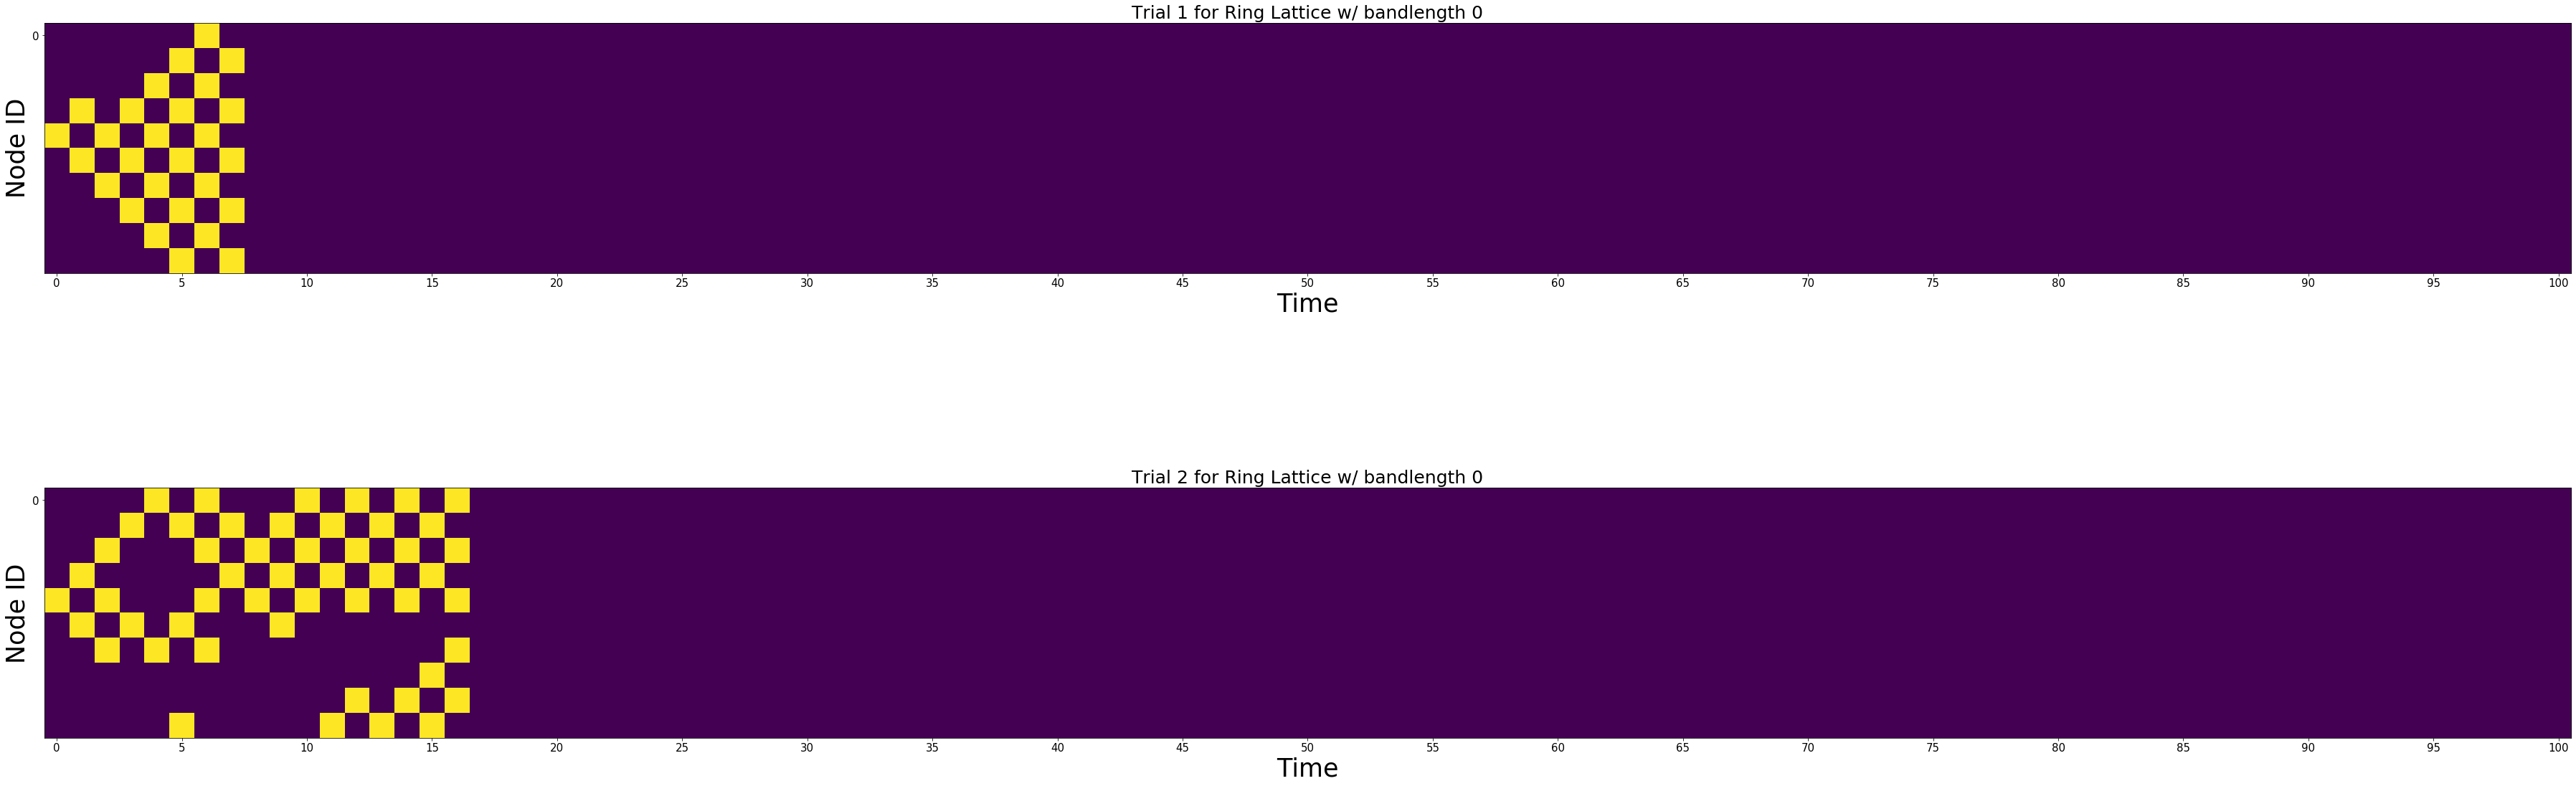

In [11]:
%%time
fig,ax = plt.subplots(2,1, figsize= (50,20))
first_excitation_times1 = ring_latt.run_excitation(Trials, p, T, seed, threshold, ax = ax)

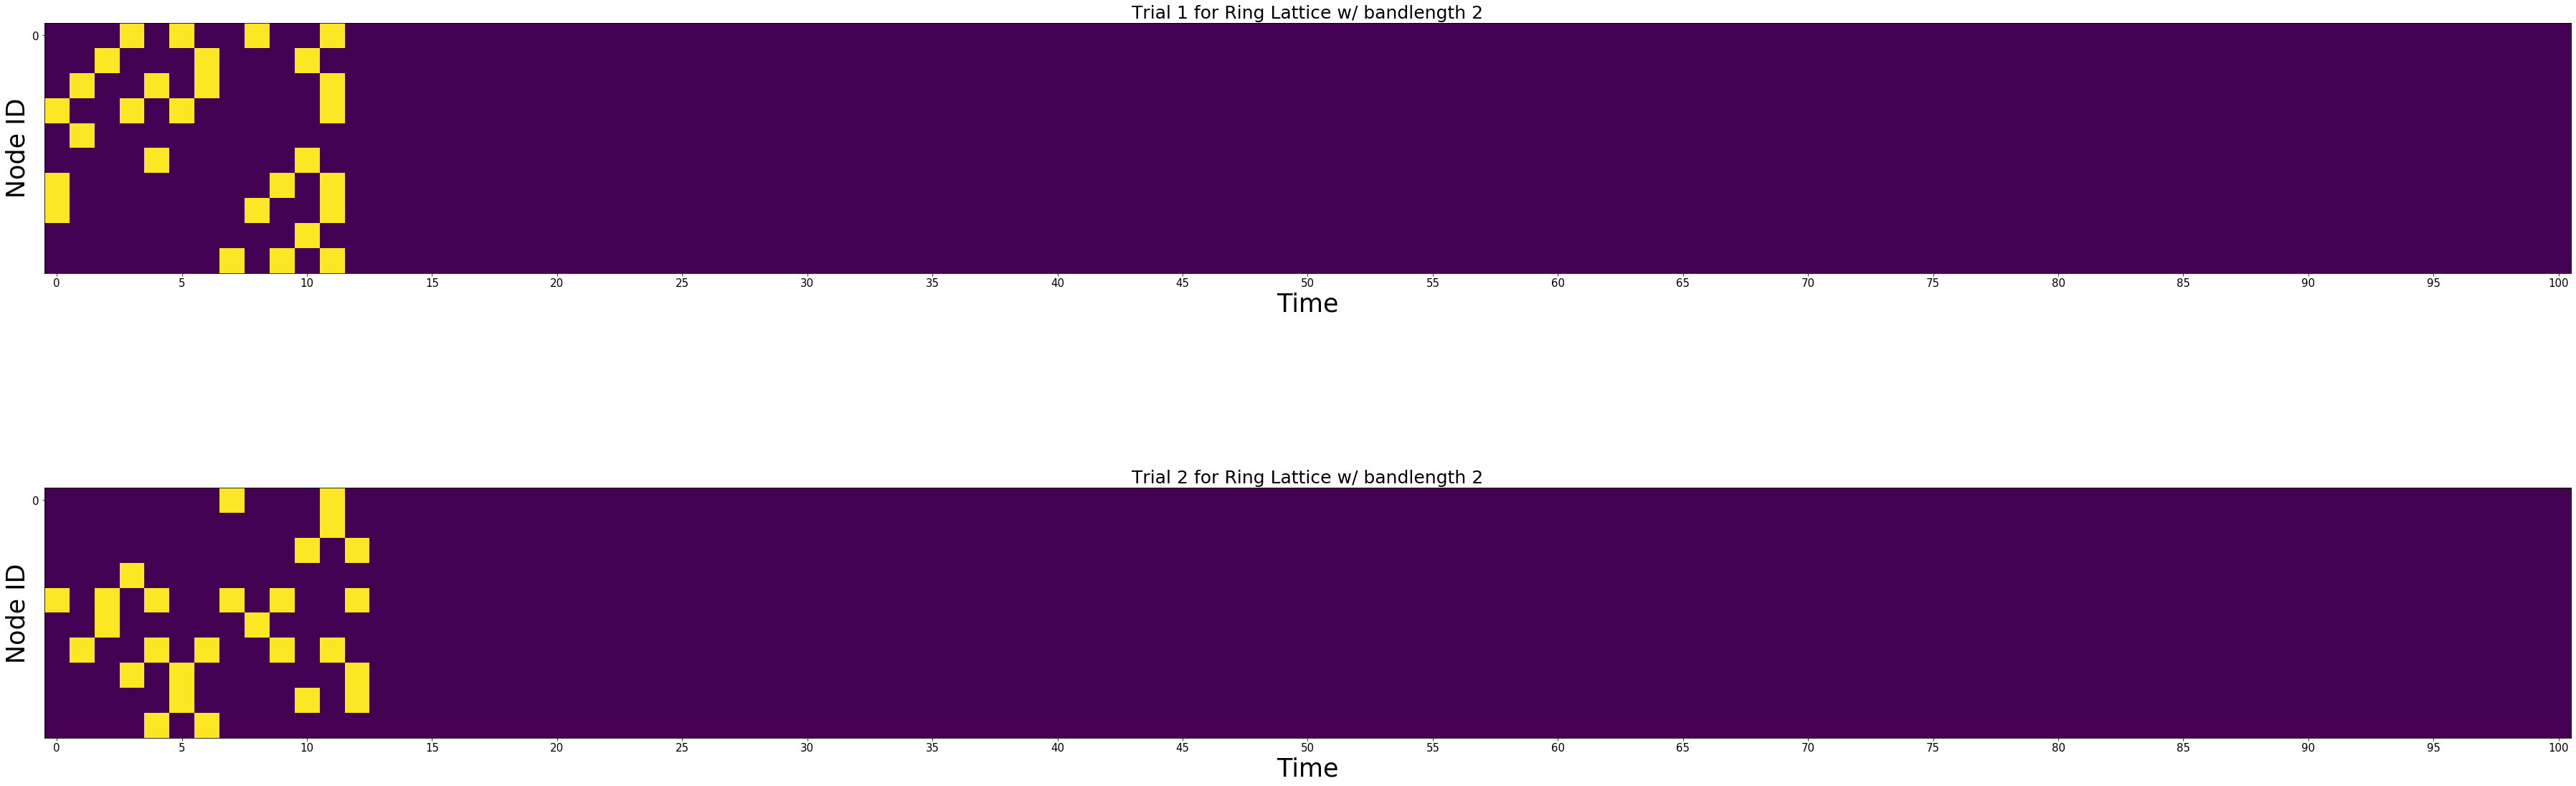

In [35]:
fig,ax = plt.subplots(2,1, figsize= (50,20))
first_excitation_times2 = banded_ring_latt.run_excitation(Trials, p, T, seed, threshold, ax = ax)

In [36]:
fig,ax = plt.subplots(2,1, figsize= (50,20))
first_excitation_times3 = ring_latt_er_noise.run_excitation(Trials, p, T, seed, threshold, ax = ax)

Error in callback <function flush_figures at 0x7fcb2129cdd0> (for post_execute):


KeyboardInterrupt: 

In [37]:
fig,ax = plt.subplots(2,1, figsize= (50,20))
first_excitation_times4 = ring_latt_k_regular.run_excitation(2, p, T, seed, threshold, ax = ax)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fcb2129cdd0> (for post_execute):


KeyboardInterrupt: 

# 3) Observing the first activation times
### input the output of the run_excitation to the .spy_first_activation() method

In [ ]:
ring_latt.spy_first_activation(first_excitation_times1)

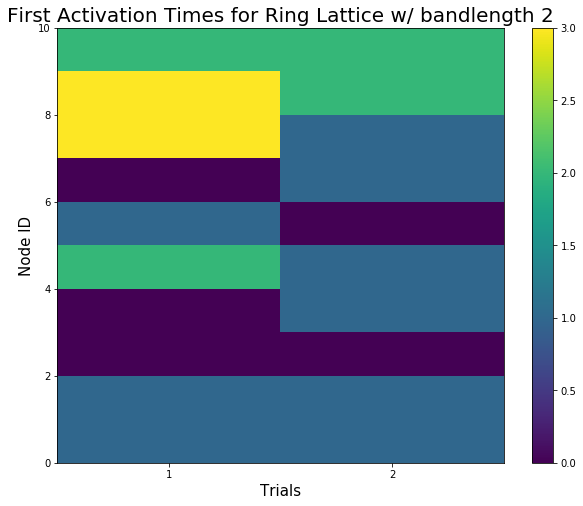

In [15]:
banded_ring_latt.spy_first_activation(first_excitation_times2)

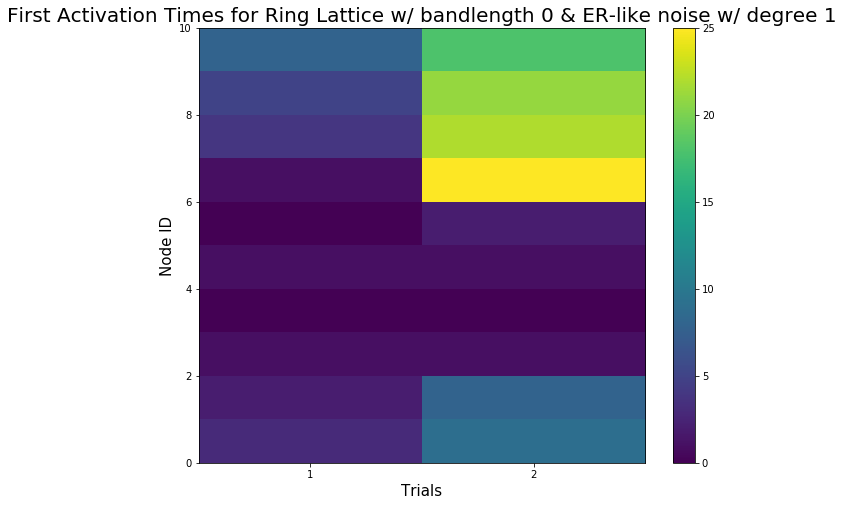

In [16]:
ring_latt_er_noise.spy_first_activation(first_excitation_times3)

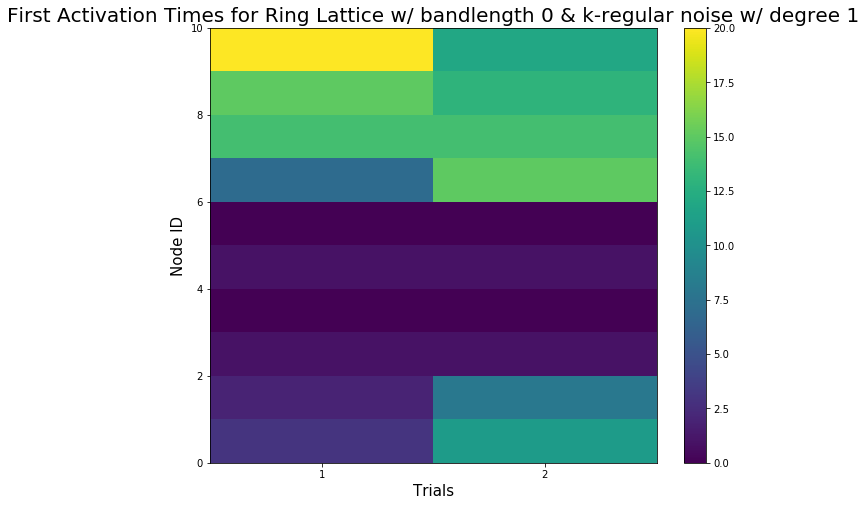

In [17]:
ring_latt_k_regular.spy_first_activation(first_excitation_times4)

# 4) You can run everything so far with make_distance_matrix
### it's gonna run the simulation starting from node i and finding first activation of node j, taking averages over the number of trials and put everything into a distance matrix

In [18]:
D1 = ring_latt.make_distance_matrix(p, T, threshold, Trials, spy_distance = False)

0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.6833603464276942
0.6833603464276942
--0.34168
0.7866506026030938
0.7866506026030938
--0.39333
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.41787684600640684
1.3063284149613708
--0.65316
0.7139274398473621
0.7139274398473621
--0.35696
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.4102686227345531
0.4102686227345531
--0.20513
0.8432294655050329
1.6251275252910495
--0.81256
0.38274762060870726
1.129415431619076
--0.56471
0.545133464490083
0.545133464490083
--0.27257
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.6912094107039755
--0.34560
0
0
--0.00000
0
0.5439084323308944
--0.27195
0.5036270736026515
0.5036270736026515
--0.25181
0
0
--0.00000
0
0.42899097486396254
--0.21450
0.6402272396185955
0.6402272396185955
--0.32011
0
0.5983728530810832
--0.29919
0
0
--0.00000
0
0.

0.3898182835692423
0.9883588756879202
--0.49418
0.7604994523117752
1.4540905481413873
--0.72705
0.5957764891134208
0.5957764891134208
--0.29789
0
0
--0.00000
0
0.5495568548649827
--0.27478
0
0.8766796860761716
--0.43834
0.6371927897235538
1.4165532658513236
--0.70828
0.5187785817142402
1.4331846121375906
--0.71659
0.5502058944334117
1.4097860336805623
--0.70489
0.8111139324596564
1.6127804769031748
--0.80639
0
0
--0.00000
0.40090421919692765
1.257793967695911
--0.62890
0
0
--0.00000
0.5403564324365809
0.5403564324365809
--0.27018
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.8435194660682217
--0.42176
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.5887477542033087
0.5887477542033087
--0.29437
0.5717605814616188
0.5717605814616188
--0.28588
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.4619849990935657
--0.2309

0
0
--0.00000
0
0.5396145523013421
--0.26981
0
0
--0.00000
0.9416621997973327
0.9416621997973327
--0.47083
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.41774567533545826
--0.20887
0.6041587586750846
0.6041587586750846
--0.30208
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.9135075104994735
--0.45675
0
0.7825385308119396
--0.39127
0
0.6059672680705722
--0.30298
0
0.5292451848121793
--0.26462
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.5162298206585475
1.0686160458653973
--0.53431
0.9368277951837742
1.7723048712097307
--0.88615
0.9785870126986652
0.9785870126986652
--0.48929
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.36065411818725845
--0.18033
0.708505239092683
1.5932949393600564
--0.79665
0
0
--0.00000
0.7365834155241182
0.7365834155241182
--0.36829
0
0
--0.00000
0
0
--0.00000
0
0.460066859859271
--0.23003
0.9004529643431459
1.8053933157968345
--0.90270
0
0
--0.00000
0
0


0.5728140576107709
0.5728140576107709
--0.28641
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.4484664521033822
0.4484664521033822
--0.22423
0
0
--0.00000
0
0
--0.00000
0
0.5529339864656482
--0.27647
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7814864970563024
--0.39074
0
0.9963276648606051
--0.49816
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7317310740374734
--0.36587
0.7364310413829781
0.7364310413829781
--0.36822
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.44887419695717323
--0.22444
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.5512296252905211
0.9653076968271008
--0.48265
0.5638218460314045
0.5638218460314045
--0.28191
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.8052321484236465
--0.40262
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000

0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7454436006398808
--0.37272
0.6798031571498119
1.6673440255205993
--0.83367
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.37335148269913276
--0.18668
0
0.6227119346631919
--0.31136
0.4666716350401039
0.4666716350401039
--0.23334
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.47540534108771937
--0.23770
0
0.7785850693393462
--0.38929
0.8739907535601561
1.367741361158359
--0.68387
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7357333516982401
--0.36787
0
0.4752157907485294
--0.23761
0.8334032494001627
0.8334032494001627
--0.41670
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.803954313186133
1.4847241657253596
--0.74236
0.8535148802713325
1.4131100526624436
--0.70656
0
0.553093287669438
--0.27655
0
0.6824040888998221
--0.34120
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.6052812352349801
--0.30264
0
0.862206380047057
--0.43110
0
0
--0.00000
0.3529327

0
0
--0.00000
0
0
--0.00000
0.896600096039606
1.5651291394098674
--0.78256
0.5362874937237372
0.5362874937237372
--0.26814
0
0
--0.00000
0.8940223533528043
0.8940223533528043
--0.44701
0
0
--0.00000
0
0.43621365064581297
--0.21811
0.3693044121204957
1.0535865609281303
--0.52679
0.9977648431063743
0.9977648431063743
--0.49888
0
0.5834113625601675
--0.29171
0
0
--0.00000
0
0
--0.00000
0.9167768112885182
1.5822207594308109
--0.79111
0.7767293409744974
1.353761996047694
--0.67688
0
0.5535730223096096
--0.27679
0
0
--0.00000
0
0
--0.00000
0
0.7645975824455455
--0.38230
0.8661905683912348
1.7065067244317196
--0.85325
0
0.38316973059806114
--0.19158
0.6628629377315604
0.6628629377315604
--0.33143
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.8065498055590423
--0.40327
0
0.781032051172129
--0.39052
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.4612131964635515
--0.23061
0
0.585142634611648
--0.292

In [19]:
D2 = banded_ring_latt.make_distance_matrix(p, T, threshold, Trials, spy_distance = False)

0.9323428648505264
0.9323428648505264
1.754719671207309
2.7100219618705834
--0.67751
0
0.6034313216565627
0.6034313216565627
0.6034313216565627
--0.15086
0.8309948928971977
0.8309948928971977
0.8309948928971977
0.8309948928971977
--0.20775
0
0
0
0
--0.00000
0
0
0
0
--0.00000
0
0
0
0
--0.00000
0
0
0.7255068670911409
1.1598801189205197
--0.28997
0.7553702367430485
1.6334323833859168
2.1206091615599516
2.1206091615599516
--0.53015
0
0.7600348371406032
0.7600348371406032
0.7600348371406032
--0.19001
0.5438242060951269
0.5438242060951269
0.5438242060951269
1.3022601579612103
--0.32557
0
0
0
0
--0.00000
0.3604882599536463
0.3604882599536463
0.8849049229088367
0.8849049229088367
--0.22123
0.42395244157643275
0.42395244157643275
0.8955076037323398
0.8955076037323398
--0.22388
0.5990609616001159
0.5990609616001159
0.5990609616001159
1.1406338231248432
--0.28516
0
0
0
0
--0.00000
0.8023886564779649
0.8023886564779649
1.2681247863167027
1.2681247863167027
--0.31703
0
0.4534866206540672
0.45348662

0.9551806651946891
1.9024636191926043
1.9024636191926043
--0.47562
0
0
0
0.4625844645322459
--0.11565
0.5215806292482419
0.5215806292482419
0.5215806292482419
0.5215806292482419
--0.13040
0.42006646722630736
1.0935261089057693
1.5489674206548347
2.3870901096123265
--0.59677
0
0.6679634018647538
0.6679634018647538
1.600244539022346
--0.40006
0
0.8625168961500106
1.8247030031444536
1.8247030031444536
--0.45618
0.5118876857186779
0.5118876857186779
1.4316269823004477
2.3271419992128854
--0.58179
0
0.3901211970592591
0.3901211970592591
0.805134792552757
--0.20128
0
0.3734010421053582
0.3734010421053582
0.8570613497299966
--0.21427
0
0
0
0
--0.00000
0
0
0
0
--0.00000
0
0
0.39709230279111407
0.39709230279111407
--0.09927
0
0.805196329180838
0.805196329180838
0.805196329180838
--0.20130
0.4485704126470039
0.4485704126470039
1.110038958348134
1.110038958348134
--0.27751
0
0.8174342352406938
1.4697765109763763
1.4697765109763763
--0.36744
0
0
0
0
--0.00000
0
0
0.43052308213514245
0.430523082135

0.6041254531956558
1.3112070801829674
1.7889655665849051
1.7889655665849051
--0.44724
0.3738288561669265
1.0444015699516358
1.7262962468943301
2.307738930650026
--0.57693
0.7612532869870011
1.4490770189623372
1.9544660606225535
1.9544660606225535
--0.48862
0
0
0
0
--0.00000
0.9671997716110059
0.9671997716110059
0.9671997716110059
0.9671997716110059
--0.24180
0
0
0
0
--0.00000
0
0
0
0
--0.00000
0
0
0
0
--0.00000
0
0
0
0.6503783818759541
--0.16259
0
0
0.5026604344555329
0.5026604344555329
--0.12567
0
0
0
0.6516479507010787
--0.16291
0
0
0
0.5073930306324055
--0.12685
0
0.907419916605658
0.907419916605658
1.6111971660241111
--0.40280
0
0.8758959835695248
0.8758959835695248
0.8758959835695248
--0.21897
0
0
0
0
--0.00000
0
0
0.5833634911742469
1.0055854564873283
--0.25140
0
0.4265291185940392
0.4265291185940392
0.4265291185940392
--0.10663
0
0.6700884772778183
0.6700884772778183
0.6700884772778183
--0.16752
0
0.8269588130753046
1.7642131959257514
1.7642131959257514
--0.44105
0
0.95593571878

In [20]:
%%time
D3 = ring_latt_er_noise.make_distance_matrix(p, T, threshold, Trials, spy_distance = False)

0.8590721293844166
1.397345459403988
--0.69867
0.7829734027960691
0.7829734027960691
--0.39149
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7838304596552174
--0.39192
0
0.8656322987878499
--0.43282
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.9120097659474726
--0.45600
0
0.6148845953566475
--0.30744
0.5322351150853114
1.499677074935153
--0.74984
0.6666081938260329
0.6666081938260329
--0.33330
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.4551738358065718
--0.22759
0
0.6893846551973508
--0.34469
0.39028801243833766
0.979513437285123
--0.48976
0.6616632052881111
0.6616632052881111
--0.33083
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.5610886390459513
0.5610886390459513
--0.28054
0.6379396225601793
1.3323306623801154
--0.66617
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.39606625612590063
1.3646543196115495
--0.68233
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
-

--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.8698338966383036
--0.43492
0.3608185171906465
0.3608185171906465
--0.18041
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.6627230638545654
0.6627230638545654
--0.33136
0
0.6908010595503928
--0.34540
0.5630899127022846
0.5630899127022846
--0.28154
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.8484393650447236
1.7745648142365043
--0.88728
0.5862148816719408
0.5862148816719408
--0.29311
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.6479312002448477
0.6479312002448477
--0.32397
0
0.3603426309934269
--0.18017
0
0
--0.00000
0
0
--0.00000
0.590623852153635
1.0643041664646788
--0.53215
0
0
--0.00000
0
0
--0.00000
0
0.8704828012236172
--0.43524
0.4613347352235069
0.4613347352235069
--0.23067
0
0
--0.00000
0
0.6863642394130086
--0.34318
0.8746886370261816
0.8746886370261816
--0.43734
0
0
--0.00000
0
0.6864674453010134
--0.3

0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.37920623493341754
--0.18960
0.6513513963604712
0.6513513963604712
--0.32568
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.48135126528461514
0.48135126528461514
--0.24068
0
0
--0.00000
0.7442924426400707
0.7442924426400707
--0.37215
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.6161194876443127
0.6161194876443127
--0.30806
0
0
--0.00000
0
0.8983465050035233
--0.44917
0.5445989656137037
0.5445989656137037
--0.27230
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.39759251721311806
0.39759251721311806
--0.19880
0
0
--0.00000
0.600507464927185
1.433782223837886
--0.71689
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.44067359190715283
0.44067359190715283
--0.22034
0
0
--0.00000
0
0.9596496386554492
--0.47982
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.993625800439514
0.993625800439514
--0.49681
0
0
--0.00000
0.9089763773761271
1.70602

0.9081597701335404
1.8093322848087243
--0.90467
0
0
--0.00000
0
0
--0.00000
0
0.3938674434209263
--0.19693
0.581046626631558
0.581046626631558
--0.29052
0.8514252955916966
1.2277677034543575
--0.61388
0
0.4048078900568136
--0.20240
0
0.35321088653768307
--0.17661
0
0
--0.00000
0
0.6625340926387655
--0.33127
0.6765703715278608
1.2563729314980923
--0.62819
0
0.7430215412926832
--0.37151
0.4141789160912853
0.9352586769180242
--0.46763
0.8997939063414373
1.4204193394451263
--0.71021
0.8566902958883933
0.8566902958883933
--0.42835
0.9952635333432729
0.9952635333432729
--0.49763
0.6011408502247586
0.6011408502247586
--0.30057
0.8181648488607155
1.4156417001748327
--0.70782
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.5371854238309611
--0.26859
0.8810997284504402
0.8810997284504402
--0.44055
0
0.4773400200311778
--0.23867
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.9163180662296546
--0.45816
0.6930984525808688
1.4218728101411724
--0.71094
0.4835452

0.8643108493192927
1.5025190637897086
--0.75126
0.9260643806000086
0.9260643806000086
--0.46303
0
0.6819718565194888
--0.34099
0.9166586986829388
1.453448853607638
--0.72672
0
0.8883496202037441
--0.44417
0.7899697235482743
1.324937305925979
--0.66247
CPU times: user 1.46 s, sys: 333 ms, total: 1.79 s
Wall time: 2.26 s


In [21]:
%%time
D4 = ring_latt_k_regular.make_distance_matrix(p, T, threshold, Trials, spy_distance = False)

0.8817442180335009
1.3681559048818308
--0.68408
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.4238446473639199
0.4238446473639199
--0.21192
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.960486476519886
0.960486476519886
--0.48024
0.36220423498640997
0.36220423498640997
--0.18110
0.55096291030737
0.55096291030737
--0.27548
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.73035421966648
0.73035421966648
--0.36518
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.5149806194209722
0.5149806194209722
--0.25749
0
0.9653886389927806
--0.48269
0.9644660502378334
0.9644660502378334
--0.48223
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7662349739936626
--0.38312
0.6176136735644013
0.6176136735644013
--0.30881
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.673675

0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.7014785133073197
0.7014785133073197
--0.35074
0.7724724554199753
1.1856183492201706
--0.59281
0.9813254352799106
0.9813254352799106
--0.49066
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.6416202821348392
1.5915093407394902
--0.79575
0
0.42376257567437414
--0.21188
0.8405971986198851
0.8405971986198851
--0.42030
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.9991157293602686
0.9991157293602686
--0.49956
0.9565515095259001
1.6319656801046385
--0.81598
0
0.6100923073485264
--0.30505
0
0.6265035999404853
--0.31325
0.5146777877060975
0.5146777877060975
--0.25734
0
0
--0.00000
0
0
--0.00000
0.894667908994315
0.894667908994315
--0.44733
0.7786113854444618
1.6165035697325045
--0.80825
0.5296500309886699
1.0277221371756053
--0.51386
0
0
--0.00000
0
0
--0.00000
0.9130016100173277
0.9130016100173277
--0.45650
0.8402085553651855
1.6545136290154372
--0.82726
0.9763810453577494
1.4667603008509968
--0.73338
0
0.85926612

0.40445132491935953
1.1751105442265124
--0.58756
0.7744464754435902
0.7744464754435902
--0.38722
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.9355600493392352
0.9355600493392352
--0.46778
0.8935572167295124
0.8935572167295124
--0.44678
0
0.5122942541077458
--0.25615
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.5307363874318017
--0.26537
0.5202908337935525
1.0200365210245663
--0.51002
0.8085851118199466
0.8085851118199466
--0.40429
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.6283892409387923
--0.31419
0
0.4561520297773731
--0.22808
0
0.6445909020614372
--0.32230
0
0.617383413959506
--0.30869
0.9894779474851289
0.9894779474851289
--0.49474
0
0
--0.00000
0
0
--0.00000
0.5668391560137099
1.1191350308746184
--0.55957
0
0.4031588427040407
--0.20158
0.42430304598798074
0.42430304598798074
--0.21215
0.6676182442334838
0.6676182442334838
--0.33381
0
0
--0.00000
0
0
--0.00000
0
0.9901794229050829
--0.49509
0.935070056001558
1.6084195283015266
--0.80421
0
0.466242493

0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.41270444485480073
1.0156377014557458
--0.50782
0.7211912304029854
0.7211912304029854
--0.36060
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.9217610533353305
1.763698390373046
--0.88185
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.5931579337764243
--0.29658
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.8630119148009839
--0.43151
0.9014098166233516
0.9014098166233516
--0.45070
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.42785722385963687
--0.21393
0.6589135659746915
0.6589135659746915
--0.32946
0
0
--0.00000
0
0
--0.00000
0
0
--0.00

0
--0.00000
0
0.6739636007233106
--0.33698
0
0.5750020402388751
--0.28750
0.8230905410168332
0.8230905410168332
--0.41155
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.4523148178454781
--0.22616
0
0.6903971169718774
--0.34520
0.580981568652892
0.580981568652892
--0.29049
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.6176713656136963
1.2963984966479898
--0.64820
0.3904129819705273
1.0484265020384536
--0.52421
0.9333444688287087
1.454812593684946
--0.72741
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0.43440630768747035
1.4186506531128393
--0.70933
0.7134811077713067
0.7134811077713067
--0.35674
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.7960187330664811
--0.39801
0.6032761600461831
1.1608581132298386
--0.58043
0
0.7394024160453649
--0.36970
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.5410963573723776
--0.27055
0.7295888166637702
1.2409954770844442
--0.62050
0
0
--0.00000
0
0
--0.00000
0
0
-

0
0
--0.00000
0
0.7669827088169351
--0.38349
0
0.7394597687252488
--0.36973
0.39791097833599054
0.39791097833599054
--0.19896
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.6165097524966578
--0.30825
0.8435888073333256
1.836992103952166
--0.91850
0.5764747891446411
1.1949868590466042
--0.59749
0.9483048983012139
0.9483048983012139
--0.47415
0.6398945039007025
0.6398945039007025
--0.31995
0
0
--0.00000
0
0.5951370023984045
--0.29757
0.595010084873233
1.3551911103325884
--0.67760
0.3651494154857804
1.0635697756018234
--0.53178
0.45934598113042924
0.45934598113042924
--0.22967
0.4639660947562183
0.8750231088082455
--0.43751
0
0.9146905023690675
--0.45735
0.894941950417769
1.737832551207406
--0.86892
0
0.795273753008258
--0.39764
0
0
--0.00000
0.37071282079674384
1.348533025274459
--0.67427
0
0.7476911367054981
--0.37385
0.5222666328031679
0.9946723287977509
--0.49734
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0
--0.00000
0
0.5882003087032889
--0.2

# 5) You can look at the persistence diagrams of the above distance matrices
### Then compute the lifetime difference between largest two 1d-voids

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.17391304347826086, 0.21739130434782608)),
  (0, (0.0, inf)),
  (0, (0.0, 0.13043478260869565)),
  (0, (0.0, 0.043478260869565216)),
  (0, (0.0, 0.043478260869565216)),
  (0, (0.0, 0.043478260869565216)),
  (0, (0.0, 0.043478260869565216)),
  (0, (0.0, 0.043478260869565216))],
 0.043478260869565216)

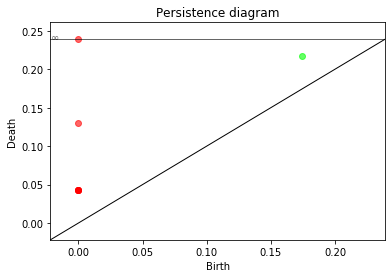

In [22]:
pers1 = ring_latt.compute_persistence(D1, spy = True)
delta1 = ring_latt.one_d_Delta(pers1)
pers1, delta1

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.25, 0.375)),
  (0, (0.0, inf)),
  (0, (0.0, 0.125)),
  (0, (0.0, 0.125)),
  (0, (0.0, 0.125)),
  (0, (0.0, 0.125)),
  (0, (0.0, 0.125)),
  (0, (0.0, 0.125))],
 0.125)

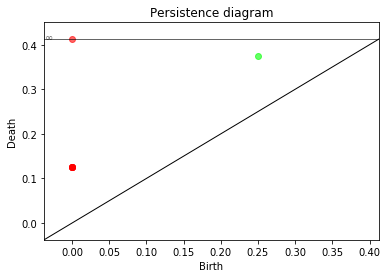

In [23]:
pers2 = banded_ring_latt.compute_persistence(D2, spy = True)
delta2 = banded_ring_latt.one_d_Delta(pers2)
pers2, delta2

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.125, 0.1875)),
  (0, (0.0, inf)),
  (0, (0.0, 0.0625)),
  (0, (0.0, 0.0625)),
  (0, (0.0, 0.0625)),
  (0, (0.0, 0.0625))],
 0.0625)

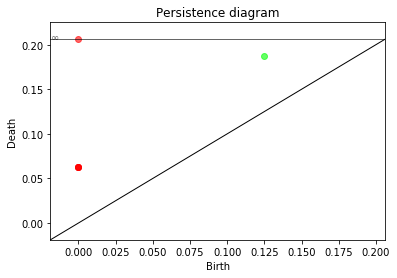

In [24]:
pers3 = ring_latt_er_noise.compute_persistence(D3, spy = True)
delta3 = ring_latt_er_noise.one_d_Delta(pers3)
pers3, delta3

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.16666666666666666, 0.4166666666666667)),
  (1, (0.25, 0.4166666666666667)),
  (0, (0.0, inf)),
  (0, (0.0, 0.08333333333333333))],
 0.08333333333333331)

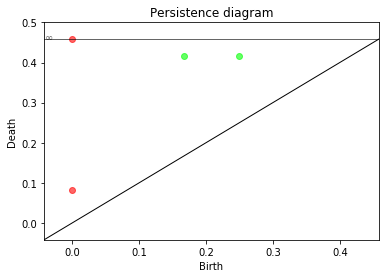

In [25]:
pers4 = ring_latt_k_regular.compute_persistence(D4, spy = True)
delta4 = ring_latt_k_regular.one_d_Delta(pers4)
pers4, delta4